In [90]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt

all_data = pd.read_csv('sales所在周次节假日.csv')
all_data.rename(columns={'店铺名称':'store','地理位置指数':'position','年份':'years','周次':'weeks of year','是否包含法定节假日':'Isholiday','季节':'season','大类':'item','销量':'sales','均价':'prices','促销':'discount'},inplace=True)
all_data['weeks'] = all_data['weeks of year']

In [91]:
a = all_data
week_5 = a.loc[lambda a : a['years'] == 2015]
week_6 = a.loc[lambda a : a['years'] == 2016]
week_6['weeks'] += 53
a = pd.concat([week_5,week_6])

/home/lin/anaconda3/envs/boost/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [92]:
from sklearn import preprocessing

#map店铺名称
name = a['store']
le = preprocessing.LabelEncoder()
le.fit(name)
list(name)
le.transform(name)
tmp = le.transform(name)
a['store'] = tmp

#map合并大类
category = a['item']
le.fit(category)
list(category)
le.transform(category)
tmp = le.transform(category)
a['item'] = tmp

#map季节
season = a['season']
le.fit(season)
list(season)
le.transform(season)
tmp = le.transform(season)
a['season'] = tmp


In [93]:
#df = a
#masked_series = (df['years']==2016) & (df['weeks'].isin([53,54,55]))
#masked_series2 = (df['years']==2016) & (~(df['weeks'].isin([53,54,55])))
#df.loc[(masked_series), 'train_or_test'] = 'test'
#df.loc[(masked_series2), 'train_or_test'] = 'no_train'
#print('Train shape: {}'.format(df.loc[df['years']==2015,:].shape))
#print('Test shape: {}'.format(df.loc[df.train_or_test=='test',:].shape))


In [94]:
#df_n = df.drop(['train_or_test'],axis=1)
df_n = a

In [95]:
#df_n['sales'] = np.log1p(df_n.sales.values)
df_n['prices'] = np.log1p(df_n.sales.values)
df_n.sample(2)

,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
5027,8,7,2015,21,0,2,11,4,1.609438,0.474704,21
11394,18,1,2016,20,0,2,11,1,0.693147,0.450479,73


In [96]:
df_n.describe()

,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
count,18163.000000,18163.000000,18163.000000,18163.000000,18163.000000,18163.000000,18163.00000,18163.000000,18163.000000,18163.000000,18163.000000
mean,14.547156,5.501569,2015.552992,27.652701,0.185432,1.597864,5.41992,7.880031,1.697586,0.364135,56.961295
std,8.695615,2.597241,0.497198,15.181708,0.388658,1.048877,2.71015,16.436671,0.880375,0.089089,30.663260
min,0.000000,1.000000,2015.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.693147,0.032120,1.000000
25%,7.000000,7.000000,2015.000000,14.000000,0.000000,1.000000,3.00000,2.000000,1.098612,0.305955,31.000000
50%,14.000000,7.000000,2016.000000,28.000000,0.000000,2.000000,6.00000,4.000000,1.609438,0.368088,59.000000
75%,22.000000,7.000000,2016.000000,40.000000,0.000000,2.000000,7.00000,9.000000,2.302585,0.420665,84.000000
max,29.000000,7.000000,2016.000000,53.000000,1.000000,3.000000,11.00000,912.000000,6.816736,0.902023,106.000000


In [97]:
''''
def one_hot_encoder(df_n, ohe_cols=['store','item','weeks of years','isholiday','season','item']):

#    One-Hot Encoder function
    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))
    df_n = pd.get_dummies(df_n, columns=ohe_cols)
    print('New df shape:{}'.format(df.shape))
    return df_n
'''

"'\ndef one_hot_encoder(df_n, ohe_cols=['store','item','weeks of years','isholiday','season','item']):\n\n#    One-Hot Encoder function\n    print('Creating OHE features..\nOld df shape:{}'.format(df.shape))\n    df_n = pd.get_dummies(df_n, columns=ohe_cols)\n    print('New df shape:{}'.format(df.shape))\n    return df_n\n"

In [98]:
outlier = df_n[lambda df_n: df_n['sales'] > 200]
#outlier.index
df_n = df_n.drop([2215, 2222, 2341, 2511, 2518, 2984, 5672, 2583, 2730, 2890, 2897,8064])

In [99]:
df_n.describe()

,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
count,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000,18151.000000
mean,14.553358,5.500909,2015.553082,27.650928,0.185499,1.597928,5.420693,7.643160,1.694903,0.364187,56.964299
std,8.694909,2.597623,0.497188,15.179253,0.388713,1.048774,2.710368,12.066473,0.874364,0.089091,30.658825
min,0.000000,1.000000,2015.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.693147,0.032120,1.000000
25%,7.000000,7.000000,2015.000000,14.000000,0.000000,1.000000,3.000000,2.000000,1.098612,0.306071,31.000000
50%,14.000000,7.000000,2016.000000,28.000000,0.000000,2.000000,6.000000,4.000000,1.609438,0.368168,59.000000
75%,22.000000,7.000000,2016.000000,40.000000,0.000000,2.000000,7.000000,9.000000,2.302585,0.420708,84.000000
max,29.000000,7.000000,2016.000000,53.000000,1.000000,3.000000,11.000000,195.000000,5.278115,0.902023,106.000000


In [100]:
for i in df_n['store'].drop_duplicates():
    a = df_n[lambda df_n : df_n['store'] == i]
    b = a['weeks'].drop_duplicates().count()
    print (i,b)
    if b != 106:
        s_ = df_n[lambda df_n: df_n['store'] == i]
        index_s = s_.index
        df_n = df_n.drop(index_s)

0 106
2 106
3 106
4 106
5 106
6 106
7 106
8 106
9 106
10 106
11 106
12 106
13 79
14 106
16 106
17 106
18 106
19 106
21 106
22 106
23 106
24 106
25 106
26 92
27 106
28 106
29 106
1 17
15 17
20 29


In [101]:
#df_n = df_n.drop(['prices','discount'],axis=1)

In [102]:
train = df_n[lambda df_n: df_n['years']==2015]
t1 = df_n[lambda df_n: df_n['weeks']==57]
t2 = df_n[lambda df_n: df_n['weeks']==58]
t3 = df_n[lambda df_n: df_n['weeks']==59]
#test = pd.concat([t1,t2,t3])

In [103]:
all_test = df_n[lambda df_n: df_n['years'] == 2016]
test = all_test[lambda all_test: all_test['weeks'] <82]
val_test = all_test[lambda all_test: all_test['weeks'] < 67]
#test = tmp[lambda tmp: tmp['weeks']<65]

In [104]:
#train = one_hot_encoder(train, ohe_cols=['store','item','weeks of year','Isholiday','season','item']) 

In [105]:
y_train = train['sales']
y_test = test['sales']
X_train = train.drop('sales', axis=1)
X_test = test.drop('sales', axis=1)
y_val_test = val_test['sales']
X_val_test = val_test.drop('sales',axis=1)

In [106]:
import lightgbm as lgb
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [107]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_val_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred) ** 0.5)
print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))

Starting training...
[1]	valid_0's l2: 119.196	valid_0's l1: 6.45683
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 97.1557	valid_0's l1: 5.8105
[3]	valid_0's l2: 79.4668	valid_0's l1: 5.23155
[4]	valid_0's l2: 64.9869	valid_0's l1: 4.70837
[5]	valid_0's l2: 53.3585	valid_0's l1: 4.23937
[6]	valid_0's l2: 43.7325	valid_0's l1: 3.81561
[7]	valid_0's l2: 35.9268	valid_0's l1: 3.43422
[8]	valid_0's l2: 29.6238	valid_0's l1: 3.09139
[9]	valid_0's l2: 24.556	valid_0's l1: 2.78289
[10]	valid_0's l2: 20.4	valid_0's l1: 2.5052
[11]	valid_0's l2: 17.0409	valid_0's l1: 2.25543
[12]	valid_0's l2: 14.3176	valid_0's l1: 2.03076
[13]	valid_0's l2: 12.1156	valid_0's l1: 1.82874
[14]	valid_0's l2: 10.3163	valid_0's l1: 1.6466
[15]	valid_0's l2: 8.86936	valid_0's l1: 1.48522
[16]	valid_0's l2: 7.73361	valid_0's l1: 1.34125
[17]	valid_0's l2: 6.81033	valid_0's l1: 1.21189
[18]	valid_0's l2: 6.05385	valid_0's l1: 1.09531
[19]	valid_0's l2: 5.43438	valid_0's l1: 0.990257
[2

In [108]:
y_pred_ = pd.DataFrame(y_pred,columns = ['pred'])
y_val_test = pd.DataFrame(y_val_test)
y_val_test_ = y_val_test.reset_index().drop(['index'],axis=1)
y_pred_['test'] = y_val_test_['sales']
#y_pred_
#y_val_test_

In [109]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 *np.sum(errors) / len(y_true)

#print(smape(y_pred_['pred'],y_pred_['test']))

In [110]:
def mae(y_pred, y_true):
    errors = abs(y_pred - y_true)
    return np.sum(errors) / len(y_true)

In [111]:
def mape(y_pred, y_true):
    # calculate error
    #denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs((y_pred - y_true) / y_true)
    return 100 *np.sum(errors) / len(y_true)

In [117]:
df = pd.DataFrame({
                    1:[1,2,3],
                    2:[1,2,3]
})

mape(df[1] ,df[2])

0.0

In [122]:
import xgboost as xgb

model = xgb.XGBRegressor(n_jobs=-1)

model_f = model.fit(X_train, y_train)


# predict
y_pred = model_f.predict(X_val_test)

# eval
# print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred ** 0.5))
# print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))

y_pred = pd.DataFrame(y_pred)
y_pred = round(y_pred)
df = pd.concat([y_val_test.reset_index().drop(['index'],axis=1),round(y_pred[0])],axis=1)

print('The rmse of prediction is:', mean_squared_error(df[0],df['sales']) ** 0.5)
print('The R^2 of prediction is:', r2_score(df[0],df['sales']))
print('The smape of prediction is:',smape(df[0],df['sales']))
print('The mae of prediction is:',mae(df[0],df['sales']))
print('The mape of prediction is:',mape(df[0],df['sales']))
#pd.concat([list(y_pred[0]),list(y_val_test['sales'])],axis=1)
#pd.concat([y_val_test.reset_index().drop(['index'],axis=1),round(y_pred[0])],axis=1)


The rmse of prediction is: 0.16285758600763967
The R^2 of prediction is: 0.999864511072736
The smape of prediction is: 0.01450211327219326
The mae of prediction is: 0.012770137524557957
The mape of prediction is: 0.014423853677053317


In [ ]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)


The rmse of prediction is: 1.862641181575228
The R^2 of prediction is: 0.9823996136752655


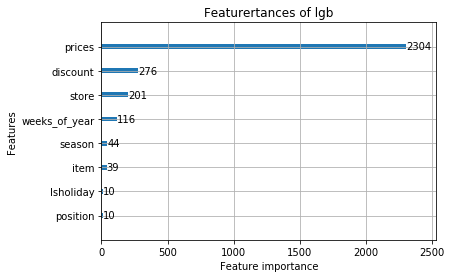

In [23]:
# model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=720,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.2319,
#                               feature_fraction_seed=9, bagging_seed=9,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# model_lgb = lgb.LGBMRegressor(boosting='goss')
model_lgb = lgb.LGBMRegressor(njob=-1)

model_lgb_t = model_lgb.fit(X_train,y_train)

# predict
y_pred = model_lgb_t.predict(X_val_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred) ** 0.5)
print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))

import matplotlib.pylab as plt

#plt.figure(figsize=(12,6))
lgb.plot_importance(model_lgb_t, max_num_features=30)
plt.title("Featurertances of lgb")
plt.show()

In [24]:
from sklearn import svm
X = [[0, 0], [2, 2]]
y = [0.5, 2.5]
clf = svm.SVR()
clf.fit(X, y) 



clf.predict([[1, 1]])

array([1.5])

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(activation='identity')

model_f = model.fit(X_train, y_train)


# predict
y_pred = model_f.predict(X_val_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred) ** 0.5)
print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))

The rmse of prediction is: 9.447568956474656
The R^2 of prediction is: 0.5472025835498152


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

#X, y = make_regression(n_features=4, n_informative=2,
#                       random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
model_r = regr.fit(X_train, y_train)  

# predict
y_pred = model_r.predict(X_val_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred) ** 0.5)
print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))

print(regr.feature_importances_)

#print(regr.predict([[0, 0, 0, 0]]))


The rmse of prediction is: 4.268463479598912
The R^2 of prediction is: 0.907571279878607
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [27]:
from sklearn import svm


model = svm.SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
model_f = model.fit(X_train, y_train)


# predict
y_pred = model_f.predict(X_val_test)
# eval
print('The rmse of prediction is:', mean_squared_error(y_val_test, y_pred) ** 0.5)
print('The R^2 of prediction is:', r2_score(y_val_test, y_pred))


The rmse of prediction is: 14.471665234827642
The R^2 of prediction is: -0.06243119675438025


In [28]:
from sklearn import datasets, linear_model
# Load the diabetes dataset
diabetes = datasets.load_diabetes()


# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]

# Split the data into training/testing sets
#diabetes_X_train = diabetes_X[:-20]
#diabetes_X_test = diabetes_X[-20:]
diabetes_X_train = df_n[lambda df_n: df_n['years'] == 2015][['store', 'years',  'Isholiday', 'season','item', 'prices', 'discount', 'weeks']]
diabetes_X_test = df_n[lambda df_n: df_n['years'] == 2016][['store', 'years',  'Isholiday', 'season','item', 'prices', 'discount', 'weeks']]

# Split the targets into training/testing sets
#diabetes_y_train = diabetes.target[:-20]
#diabetes_y_test = diabetes.target[-20:]
diabetes_y_train = df_n[lambda df_n: df_n['years'] == 2015]['sales']
diabetes_y_test = df_n[lambda df_n: df_n['years'] == 2016]['sales']
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients:', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))


Coefficients: [-1.90234024e-02  1.33226763e-15  6.39718448e-02 -3.24211769e-01
  1.05183302e-02  1.19004422e+01 -7.96497881e+00 -9.24662836e-03]
Mean squared error: 44.86
Variance score: 0.66


In [29]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

print(smape(diabetes_y_pred,diabetes_y_test))

91.40102189402621


In [30]:
from sklearn import datasets, linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import datasets

diabetes = datasets.load_diabetes()
diabetes_X = diabetes.data[:, np.newaxis, 8]

regL = linear_model.Lasso
regR = linear_model.Ridge

regL = linear_model.Lasso(alpha=0.1)
regR = linear_model.Ridge(alpha=0.5)
df_nR = df_n[lambda df_n: df_n['years'] == 2015].drop(['sales'],axis=1)
#diabetes_X_train = df_n[lambda df_n: df_n['years'] == 2015]
df_nR = df_n[lambda df_n: df_n['years'] == 2016].drop(['sales'],axis=1)
#diabetes_X_test = df_n[lambda df_n: df_n['years'] == 2016]

diabetes_y_train = df_n[lambda df_n: df_n['years'] == 2015]['sales']
diabetes_y_test = df_n[lambda df_n: df_n['years'] == 2016]['sales']

regL.fit(diabetes_X_train, diabetes_y_train,[0,1])
regR.fit(diabetes_X_train, diabetes_y_train,[0,1])

diabetes_y_pred_L = regL.predict(diabetes_X_test)
diabetes_y_pred_R = regR.predict(diabetes_X_test)


# The coefficients
print('Coefficients:', regL.coef_)
# The mean squared error
print("Lasso Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred_L))
print("Ridge Mean squared error: %.2f"
      % mean_squared_error(diabetes_y_test, diabetes_y_pred_R))
# Explained variance score: 1 is perfect prediction
#print('Variance score: %.2f' % r2_score(diabetes_y_test, diabetes_y_pred))

ValueError: Length of weights not compatible with specified axis.

In [ ]:
def smape(y_pred, y_true):
    # calculate error
    denom = (abs(y_pred) + abs(y_true)) / 2
    errors = abs(y_pred - y_true) / denom
    return 100 * np.sum(errors) / len(y_true)

print(smape(diabetes_y_pred,diabetes_y_test))